In [1]:
from sc_spectrum.scml import rbf_neighbor_graph
from sc_spectrum.scml import sparse_spectral
from sc_spectrum.scml import scml
from sc_spectrum.scml import spectral_clustering
from sc_spectrum.scml import soft_scml

from sc_spectrum.visualization import umap_embed, umap_scatter, recolor_clusters

/home/groups/song/songlab2/jacobrl3/sc-spectrum/venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from time import asctime, localtime

import numpy as np
import pandas as pd

import scipy
from scipy.sparse import csr_matrix
from scipy.sparse import diags
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score

import torch

from typing import Tuple
from typing import List

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import seaborn as sns

plt.style.use('default')
rcParams['font.size'] = 11
rcParams['pdf.fonttype'] = 42
plt.rcParams.update({"text.color": 'k'})

In [3]:
use_gpu = True

if use_gpu and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


### Generate trimodal dataset

In [4]:
from sklearn.datasets import make_blobs

labels = np.array( [0] * 50 + [1] * 30 + [2] * 20 )

m, sigma = 2, 2

i = 1
X, y = make_blobs(n_samples=[50,30,20], n_features=m, cluster_std=sigma, shuffle=False, random_state=i)
graph = rbf_neighbor_graph(X, k=5, a=5)
graph1 = graph


i = 2
X, y = make_blobs(n_samples=[50,30,20], n_features=m, cluster_std=sigma, shuffle=False, random_state=i)
graph = rbf_neighbor_graph(X, k=5, a=5)
graph2 = graph


i = 4
X, y = make_blobs(n_samples=[50,30,20], n_features=m, cluster_std=sigma, shuffle=False, random_state=i)
graph = rbf_neighbor_graph(X, k=5, a=5)
graph3 = graph

### Spectral clustering for each modality

In [5]:
n_clust = 3

In [6]:
L_1, w_1, v_1 = sparse_spectral(graph1, n_clust = n_clust)

cl_1 = spectral_clustering(v_1, n_clust = n_clust)

In [7]:
L_2, w_2, v_2 = sparse_spectral(graph2, n_clust = n_clust)

cl_2 = spectral_clustering(v_2, n_clust = n_clust)

In [8]:
L_3, w_3, v_3 = sparse_spectral(graph3, n_clust = n_clust)

cl_3 = spectral_clustering(v_3, n_clust = n_clust)

Text(0.5, 1.0, 'Graph Laplacian eigen spectrum for synthetic dataset')

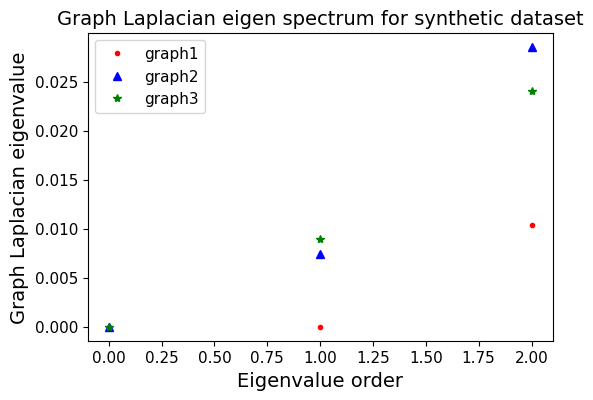

In [9]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

l1, = plt.plot(w_1, 'r.')
l2, = plt.plot(w_2, 'b^')
l3, = plt.plot(w_3, 'g*')

ax.legend(handles=[l1, l2, l3], labels=["graph1", "graph2", "graph3"])
ax.set_xlabel("Eigenvalue order", fontsize=14)
ax.set_ylabel("Graph Laplacian eigenvalue", fontsize=14)

ax.set_title("Graph Laplacian eigen spectrum for synthetic dataset", fontsize=14)

### SCML clustering of trimodal dataset

In [10]:
print("Start: {}".format(asctime(localtime())))
w_scml_a1, v_scml_a1, cl_scml_a1 = scml([graph1, graph2, graph3], n_clust=n_clust, device=device, alpha=1.0)
print("End: {}".format(asctime(localtime())))

Start: Fri May 20 14:49:49 2022
End: Fri May 20 14:50:12 2022


Text(0.5, 1.0, 'SCML ($\\alpha = 1$)')

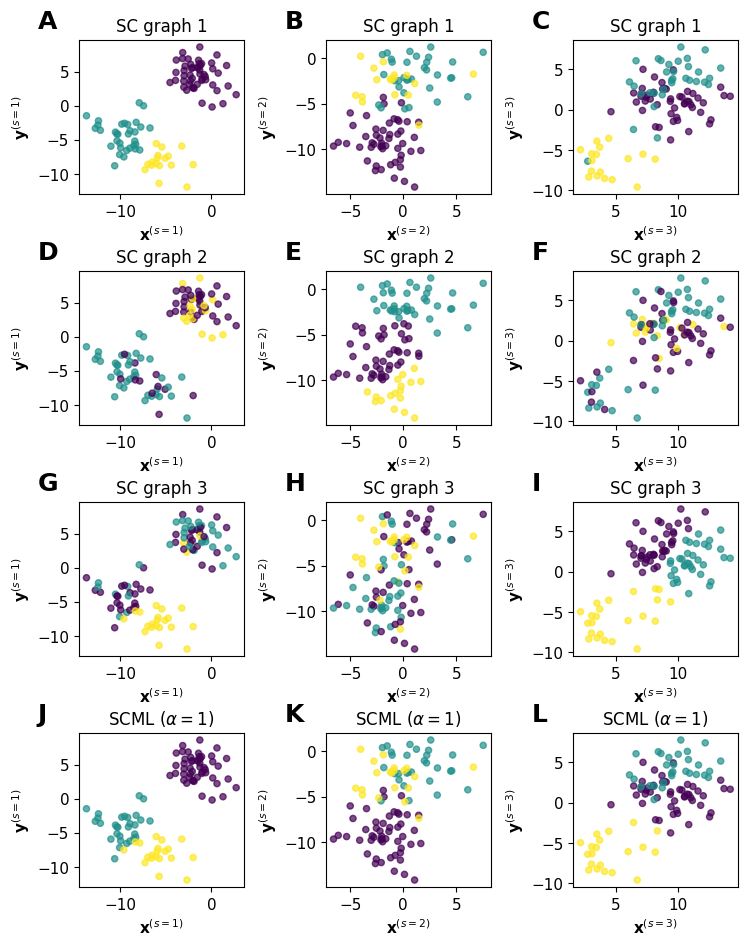

In [11]:
fig, axes = plt.subplots(4, 3, figsize=(8.5,11), 
                         gridspec_kw={'hspace': 0.5,
                                      'wspace': 0.5} )

# Graph 1 axes

X, y = make_blobs(n_samples=[50,30,20], n_features=m, cluster_std=sigma, shuffle=False, random_state=1)

# Graph 1 SC
ax = axes[0][0]
ax.scatter(X[:,0], X[:,1], c=cl_1, s=20, alpha=0.7)
ax.set_title(f'Layer    (s={1})\n')
ax.set_xlabel(r'$\mathbf{x}^{(s=1)}$')
ax.set_ylabel(r'$\mathbf{y}^{(s=1)}$')
ax.text(-0.25, 1.2, 'A', ha='left', va='top', transform=ax.transAxes, fontsize=18, weight='bold')

ax.set_title(r"SC graph 1", fontsize=12)

# Graph 2 SC
ax = axes[1][0]
ax.scatter(X[:,0], X[:,1], c=cl_2, s=20, alpha=0.7)
ax.set_title(f'Layer    (s={1})\n')
ax.set_xlabel(r'$\mathbf{x}^{(s=1)}$')
ax.set_ylabel(r'$\mathbf{y}^{(s=1)}$')
ax.text(-0.25, 1.2, 'D', ha='left', va='top', transform=ax.transAxes, fontsize=18, weight='bold')

ax.set_title(r"SC graph 2", fontsize=12)

# Graph 3 SC
ax = axes[2][0]
ax.scatter(X[:,0], X[:,1], c=cl_3, s=20, alpha=0.7)
ax.set_title(f'Layer    (s={1})\n')
ax.set_xlabel(r'$\mathbf{x}^{(s=1)}$')
ax.set_ylabel(r'$\mathbf{y}^{(s=1)}$')
ax.text(-0.25, 1.2, 'G', ha='left', va='top', transform=ax.transAxes, fontsize=18, weight='bold')

ax.set_title(r"SC graph 3", fontsize=12)

# SCML
ax = axes[3][0]
ax.scatter(X[:,0], X[:,1], c=cl_scml_a1, s=20, alpha=0.7)
ax.set_title(f'Layer    (s={1})\n')
ax.set_xlabel(r'$\mathbf{x}^{(s=1)}$')
ax.set_ylabel(r'$\mathbf{y}^{(s=1)}$')
ax.text(-0.25, 1.2, 'J', ha='left', va='top', transform=ax.transAxes, fontsize=18, weight='bold')

ax.set_title(r"SCML ($\alpha = 1$)", fontsize=12)


# Graph 2 axes

X, y = make_blobs(n_samples=[50,30,20], n_features=m, cluster_std=sigma, shuffle=False, random_state=2)

# Graph 1 SC
ax = axes[0][1]
ax.scatter(X[:,0], X[:,1], c=cl_1, s=20, alpha=0.7)
ax.set_title(f'Layer    (s={2})\n')
ax.set_xlabel(r'$\mathbf{x}^{(s=2)}$')
ax.set_ylabel(r'$\mathbf{y}^{(s=2)}$')
ax.text(-0.25, 1.2, 'B', ha='left', va='top', transform=ax.transAxes, fontsize=18, weight='bold')

ax.set_title(r"SC graph 1", fontsize=12)

# Graph 2 SC
ax = axes[1][1]
ax.scatter(X[:,0], X[:,1], c=cl_2, s=20, alpha=0.7)
ax.set_title(f'Layer    (s={2})\n')
ax.set_xlabel(r'$\mathbf{x}^{(s=2)}$')
ax.set_ylabel(r'$\mathbf{y}^{(s=2)}$')
ax.text(-0.25, 1.2, 'E', ha='left', va='top', transform=ax.transAxes, fontsize=18, weight='bold')

ax.set_title(r"SC graph 2", fontsize=12)

# Graph 3 SC
ax = axes[2][1]
ax.scatter(X[:,0], X[:,1], c=cl_3, s=20, alpha=0.7)
ax.set_title(f'Layer    (s={2})\n')
ax.set_xlabel(r'$\mathbf{x}^{(s=2)}$')
ax.set_ylabel(r'$\mathbf{y}^{(s=2)}$')
ax.text(-0.25, 1.2, 'H', ha='left', va='top', transform=ax.transAxes, fontsize=18, weight='bold')

ax.set_title(r"SC graph 3", fontsize=12)

# SCML
ax = axes[3][1]
ax.scatter(X[:,0], X[:,1], c=cl_scml_a1, s=20, alpha=0.7)
ax.set_title(f'Layer    (s={2})\n')
ax.set_xlabel(r'$\mathbf{x}^{(s=2)}$')
ax.set_ylabel(r'$\mathbf{y}^{(s=2)}$')
ax.text(-0.25, 1.2, 'K', ha='left', va='top', transform=ax.transAxes, fontsize=18, weight='bold')

ax.set_title(r"SCML ($\alpha = 1$)", fontsize=12)


# Graph 3 axes

X, y = make_blobs(n_samples=[50,30,20], n_features=m, cluster_std=sigma, shuffle=False, random_state=4)

# Graph 1 SC
ax = axes[0][2]
ax.scatter(X[:,0], X[:,1], c=cl_1, s=20, alpha=0.7)
ax.set_title(f'Layer    (s={3})\n')
ax.set_xlabel(r'$\mathbf{x}^{(s=3)}$')
ax.set_ylabel(r'$\mathbf{y}^{(s=3)}$')
ax.text(-0.25, 1.2, 'C', ha='left', va='top', transform=ax.transAxes, fontsize=18, weight='bold')

ax.set_title(r"SC graph 1", fontsize=12)

# Graph 2 SC
ax = axes[1][2]
ax.scatter(X[:,0], X[:,1], c=cl_2, s=20, alpha=0.7)
ax.set_title(f'Layer    (s={3})\n')
ax.set_xlabel(r'$\mathbf{x}^{(s=3)}$')
ax.set_ylabel(r'$\mathbf{y}^{(s=3)}$')
ax.text(-0.25, 1.2, 'F', ha='left', va='top', transform=ax.transAxes, fontsize=18, weight='bold')

ax.set_title(r"SC graph 2", fontsize=12)

# Graph 3 SC
ax = axes[2][2]
ax.scatter(X[:,0], X[:,1], c=cl_3, s=20, alpha=0.7)
ax.set_title(f'Layer    (s={3})\n')
ax.set_xlabel(r'$\mathbf{x}^{(s=3)}$')
ax.set_ylabel(r'$\mathbf{y}^{(s=3)}$')
ax.text(-0.25, 1.2, 'I', ha='left', va='top', transform=ax.transAxes, fontsize=18, weight='bold')

ax.set_title(r"SC graph 3", fontsize=12)

# SCML
ax = axes[3][2]
ax.scatter(X[:,0], X[:,1], c=cl_scml_a1, s=20, alpha=0.7)
ax.set_title(f'Layer    (s={3})\n')
ax.set_xlabel(r'$\mathbf{x}^{(s=3)}$')
ax.set_ylabel(r'$\mathbf{y}^{(s=3)}$')
ax.text(-0.25, 1.2, 'L', ha='left', va='top', transform=ax.transAxes, fontsize=18, weight='bold')

ax.set_title(r"SCML ($\alpha = 1$)", fontsize=12)

In [12]:
print("graph 1 Spectral - True labels = {}".format(normalized_mutual_info_score(cl_1, labels)))
print("graph 2 Spectral - True labels = {}".format(normalized_mutual_info_score(cl_2, labels)))
print("graph 3 Spectral - True labels = {}".format(normalized_mutual_info_score(cl_3, labels)))

print("SCML - True labels = {}".format(normalized_mutual_info_score(cl_scml_a1, labels)))

graph 1 Spectral - True labels = 0.9094258770765347
graph 2 Spectral - True labels = 0.46329934953217444
graph 3 Spectral - True labels = 0.4359294146710843
SCML - True labels = 1.0


In [13]:
v_scml_norm = v_scml_a1[:, :n_clust] / np.linalg.norm(v_scml_a1[:, :n_clust], axis = 1, keepdims = True)

embedding_pytorch = umap_embed(v_scml_norm, n_clust)

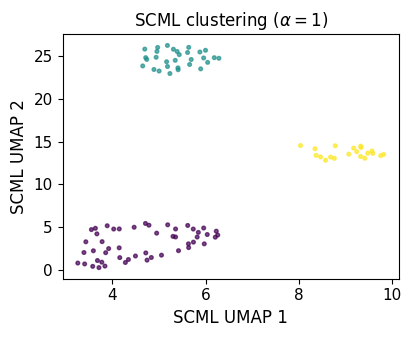

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 3.5))

ax.scatter(embedding_pytorch[:,0], embedding_pytorch[:,1], c = cl_scml_a1, s = 7, alpha = 0.7)

ax.set_xlabel("SCML UMAP 1", fontsize=12)
ax.set_ylabel("SCML UMAP 2", fontsize=12)
ax.set_title(r"SCML clustering $(\alpha = 1)$", fontsize = 12)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/synthetic-data-scml-clust-umap-a1.pdf", format="pdf", transparent=True)